### README:

This notebook is used to plot the shannon indices for the 16% resistant, low migration rate runs.

Much the same as the original shannon plotter notebook, but that was getting a bit too cluttered so we'll do a tidier version here.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.ticker as ticker
import matplotlib.pylab as pl
from itertools import cycle
import matplotlib.gridspec as gridspec
import glob
import collections
import math
import re
import os
from collections import defaultdict
import string
from matplotlib.ticker import FormatStrFormatter

plt.rcParams["font.family"] = "Times New Roman"
params = {'mathtext.default': 'regular' }          
plt.rcParams.update(params)

In [2]:
def getEventCountersDataframe(date, pc_res, phase, sigma, duration):
    
    return pd.read_csv("geno_distb_data_"+phase+"/"+str(pc_res)+"_resistant-"+date+"-migration_rate-0.1/"+str(pc_res)+"_resistant-"+date+"-migration_rate-0.1-event_counters-sigma="+"{:.5f}".format(sigma)+"-t="+str(duration)+".0.csv")


In [4]:
g_max = 0.083
nRuns = 100
nRuns_list = [r for r in range(nRuns)]
dates = ["5-Jan-2022"]
duration = 4368 #duration of sims in hours - equivalent to 26 weeks
pc_res = 16 #percentages of the population which have an innante resistance to the biocide
phase2_str = "phase2"
log_norm_params_16pcRes = [2.47772924764521, 0.7060073500033884]


#event counters dataframes
event_counters_16pc_05Jan = getEventCountersDataframe(dates[0], pc_res, phase2_str, log_norm_params_16pcRes[1], duration)

In [5]:
#paths to the directories containing the processed shannon data csv files for runs which exhibited GROWTH
shannon_directory_16pc_05Jan_GROWTH = "shannon_calculations_phase2_GROWTH/16_pc_res-5-Jan-2022-migration_rate-0.1/"

In [6]:
#lists of the runs which exhibited growth
#growth
GROWTH_RUNS_16pc_05Jan = list(event_counters_16pc_05Jan["runID"][(event_counters_16pc_05Jan["bf_thickness"] > 0)])

In [7]:
def combineShannonDataIntoDict(filepath, pc_res, nRuns):
    '''
    This iterates over all the csv files of the processed shannon data and collates them into a dictionary.
    
    The keys to this dictionary are the runIDs, the values in this dictionary are dataframes of the shannon data over time.
    
    This shannon dict contains all the runs performed in a given session for a specific pc res.
    
    e.g., all the 14-Oct runs for 14% resistant.  We then combine these using collateShannonDicts so that we have a dict containing all runs from all sessions for a given pc_res
    '''
    
    shannon_dict = {}
    
    for runID in nRuns:
        #the "/" is included in the filepath
        shannon_dict["runID_"+str(runID)] = pd.read_csv(filepath+"shannon_calculations-"+str(pc_res)+"_pc_res-runID_"+str(runID)+"-migration_rate-0.1.csv")
        
    return shannon_dict

In [8]:
def collateShannonDicts(shannon_dict_list):
    '''
    this method takes in a list of the shannon dicts (the list contains dicts corresponding to the same pc_res, so all the 14% ones, or all the 15% ones, not a mixture)
    
    returns a "master" dict, containing all the shannon calculations for runs performed on different dates.
    
    So this master_dict contains all the runs performed over all sessions for a specific pc_res.
    '''
    
    master_dict = shannon_dict_list[0].copy()
    
    for shannon_dict in shannon_dict_list[1:]:
        master_dict.update(shannon_dict)
        
    return master_dict

In [9]:
def getAveragedShannonVals(shannon_data):
    '''
    this method collates all the shannon data over all the runs and averages them
    '''
    time_df = pd.DataFrame() #time
    nBac_df = pd.DataFrame() #no. of bacteria over time
    H_df = pd.DataFrame() #shannon index over time
    E_df = pd.DataFrame() #shannon equitability over time
    S_df = pd.DataFrame() #no. of species over time
    
    for runID in shannon_data.keys():
        time_df[runID] = shannon_data[runID]["t"]
        nBac_df[runID] = shannon_data[runID]["nBac"]
        H_df[runID] = shannon_data[runID]["H"]
        E_df[runID] = shannon_data[runID]["E"]
        S_df[runID] = shannon_data[runID]["S"]
        
    #print(time_df)
    t_avg = time_df.mean(axis=1)
    nBac_avg = nBac_df.mean(axis=1)
    H_avg = H_df.mean(axis=1)
    E_avg = E_df.mean(axis=1)
    S_avg = S_df.mean(axis=1)
    
    #print(t_avg)
    
    return np.array(t_avg), np.array(nBac_avg), np.array(H_avg), np.array(E_avg), np.array(S_avg)

In [10]:
def getAverageAndCollateShannonDataIntoLists(shannon_data_dict_list):
    '''
    Rather than get the shannon data dicts, extract the lists of the data and then manually combine them into a list, eg 
    H1, _, _.. = getAveragedShannonVals(shannon_dict_1)
    H2, _, _.. = getAveragedShannonVals(shannon_dict_2)
    H_list = [H1, H2]
    
    This method takes in a list of the shannon dicts, and returns lists of the collated shannon variables - i.e returns H_list etc
    
    Each element of shannon_data_dict_list is a master dict of each % resistance, so [14pc_shannon_data, 15pc_shannon_data, ...]
    '''
    t_list = []
    nBac_list = []
    H_list = []
    E_list = []
    S_list = []
    
    for shannon_dict in shannon_data_dict_list:
        
        t, nBac, H, E, S = getAveragedShannonVals(shannon_dict)
        
        t_list.append(t)
        nBac_list.append(nBac)
        H_list.append(H)
        E_list.append(E)
        S_list.append(S)
        
    #print(t_list)
        
    return t_list, nBac_list, H_list, E_list, S_list

In [14]:
#dicts where each entry is the shannon variables and the key is the runID
#all of the processed shannon data
#for when we have data from multiple dates, these dicts need to be combined into one master dict for each pc_res
#e.g. pc_res_14_24Sep_shannon_data_GROWTH + pc_res_14_16Oct_shannon_data_GROWTH = pc_res_14_shannon_data_GROWTH

#GROWTH processed shannon data
#16%
pc_res_16_05Jan_shannon_data_GROWTH = combineShannonDataIntoDict(shannon_directory_16pc_05Jan_GROWTH, pc_res=pc_res, nRuns=GROWTH_RUNS_16pc_05Jan)

pc_res_16_shannon_data_GROWTH_list = [pc_res_16_05Jan_shannon_data_GROWTH]

pc_res_16_shannon_data_GROWTH = collateShannonDicts(pc_res_16_shannon_data_GROWTH_list)

In [15]:
t_list_GROWTH, nBac_list_GROWTH, H_list_GROWTH, E_list_GROWTH, S_list_GROWTH = getAverageAndCollateShannonDataIntoLists([pc_res_16_shannon_data_GROWTH])

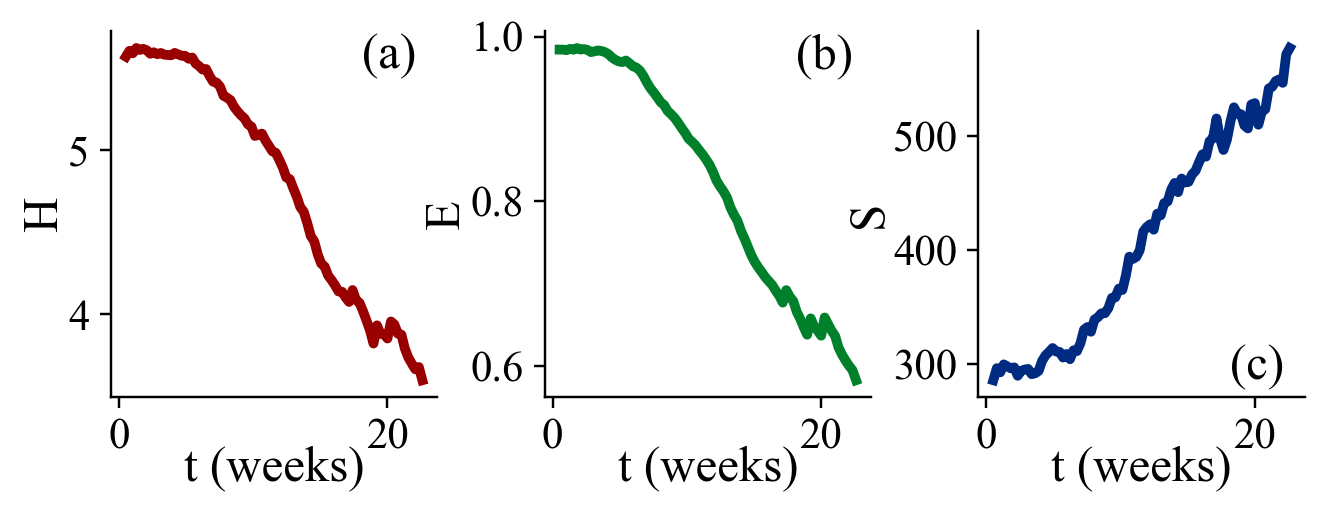

In [24]:
def plot1x3ShannonValuesVsTime(x_vals, y_vals_list):
    '''This is used to plot the shannon plots H, E, S.'''
    fig, axes = plt.subplots(1, 3, dpi=220)
    fig.set_size_inches(7,2.2)
    plt.subplots_adjust(wspace=0.33)
    titleSize = 16
    labelSize = 16
    numbersize = 14
    legendsize = 10
    lettersize = 16
    IDsize=12
    line_width = 3.2
    line_colour_S = '#002b80'
    line_colour_E = '#00802b'
    line_colour_H = '#990000'
    
    x_vals = [x/(24.*7) for x in x_vals] # rescale to weeks
    
    i = 0
    letters = list(string.ascii_lowercase)[:4]
#     x_vals_list = [x_vals_GROWTH, x_vals_GROWTH, x_vals_GROWTH_EDGE, x_vals_GROWTH_EDGE] #combine the x_data for ease of plotting
#     y_vals_list = [y_vals_GROWTH[0], y_vals_GROWTH[1], y_vals_GROWTH_EDGE[0], y_vals_GROWTH_EDGE[1]]
    y_label_list = ['H', 'E', 'S']
    line_colour_list = [line_colour_H, line_colour_E, line_colour_S]
    
    for ax, y_val, y_label, letter, line_colour in zip(axes.flat, y_vals_list, y_label_list, letters, line_colour_list):
        
        ax.plot(x_vals[2:], y_val[2:], lw=line_width, color=line_colour)
        
        if i < 2: ax.text(0.77, 0.9, "("+letter+")", transform=ax.transAxes, fontsize=lettersize)
        else: ax.text(0.77, 0.05, "("+letter+")", transform=ax.transAxes, fontsize=lettersize)
            
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.tick_params(axis='both', labelsize=numbersize)
        
        ax.set_xlabel("t (weeks)", labelpad=-4, fontsize=labelSize)
        ax.set_ylabel(y_label, labelpad=0.1, fontsize=labelSize)
        
        
        
        
        i += 1
    
    
    plt.savefig("ms_paper_plots/shannon_1x3_low_migration_rate.pdf", bbox_inches='tight', dpi=330)
    plt.show()
    
    
    
pc_index = 0 # vestige of the old way of doing things, just keep this at 0
plot1x3ShannonValuesVsTime(t_list_GROWTH[pc_index], [H_list_GROWTH[pc_index], E_list_GROWTH[pc_index], S_list_GROWTH[pc_index]])